In [ ]:
# Install required libraries
!pip install opencv-python scikit-learn

In [ ]:
# Import libraries
import zipfile
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from google.colab.patches import cv2_imshow

# Step 1: Unzip the dataset
zip_path = "/content/archive(2).zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [ ]:
zip_path = "/content/archive(2).zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [ ]:
def load_images(folder_path, img_size=(128, 128)):
    images = []
    labels = []
    class_names = os.listdir(folder_path)

    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)  # Resize image
                img = img / 255.0  # Normalize pixel values
                images.append(img)
                labels.append(class_name)
            else:
                print(f"Warning: Unable to read image {img_path}")

    return np.array(images), np.array(labels)

In [ ]:
train_path = os.path.join(extract_path, "Alzheimer_s Dataset/train")
test_path = os.path.join(extract_path, "Alzheimer_s Dataset/test")

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)

# Convert labels to numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

print("Data preprocessing complete!")
print(f"Train data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")

Data preprocessing complete!
Train data shape: (5121, 128, 128, 3), Labels shape: (5121,)
Test data shape: (1279, 128, 128, 3), Labels shape: (1279,)


--2025-02-06 03:40:56--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘/content/yolov3.cfg.2’

yolov3.cfg.2        100%[===================>]   8.15K  --.-KB/s    in 0s      

2025-02-06 03:40:56 (71.9 MB/s) - ‘/content/yolov3.cfg.2’ saved [8342/8342]

--2025-02-06 03:40:56--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘/content/yolov3.weights.2’

yolov3.weights.2    100%[===================>] 236.52M  35.5MB/

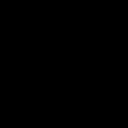

In [ ]:
# Step 3: Object Detection (using a sample image)
def detect_objects(image):
    # Load YOLO files
    !wget -P /content https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
    !wget -P /content https://pjreddie.com/media/files/yolov3.weights
    !wget -P /content https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

    # Load YOLO model
    net = cv2.dnn.readNet("/content/yolov3.weights", "/content/yolov3.cfg")
    with open("/content/coco.names", "r") as f:
        classes = f.read().strip().split("\n")

    # Get output layers
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    # Perform object detection
    height, width, channels = image.shape
    # Convert the image to uint8 before passing it to blobFromImage
    blob = cv2.dnn.blobFromImage(image.astype(np.uint8), 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # Process detections
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # Confidence threshold
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply non-max suppression
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    return boxes, indices, class_ids, classes

# Perform object detection on a sample image
sample_image = X_train[0]  # Use the first image from the training set
boxes, indices, class_ids, classes = detect_objects(sample_image)

# Draw bounding boxes on the image
for i in indices:
    box = boxes[i]
    x, y, w, h = box
    label = str(classes[class_ids[i]])
    confidence = confidences[i]
    color = (0, 255, 0)  # Green color for bounding box
    cv2.rectangle(sample_image, (x, y), (x + w, y + h), color, 2)
    cv2.putText(sample_image, f"{label} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Display the result
print("Object detection result:")
cv2_imshow(sample_image)

Epoch 1/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.4999 - loss: 0.7073 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.5000 - loss: 0.6933 - val_accuracy: 0.4999 - val_loss: 0.6931
Epoch 4/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.5000 - loss: 0.6963 - val_accuracy: 0.4999 - val_loss: 0.6931
Epoch 5/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.5001 - loss: 0.6935 - val_accuracy: 0.4999 - val_loss: 0.6931
Epoch 6/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.5002 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.4999 - loss: 0.6936 - val_accuracy: 0.4999 - val_loss: 0.6931
Epoch 8/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.5002 - loss: 0.6932 - 

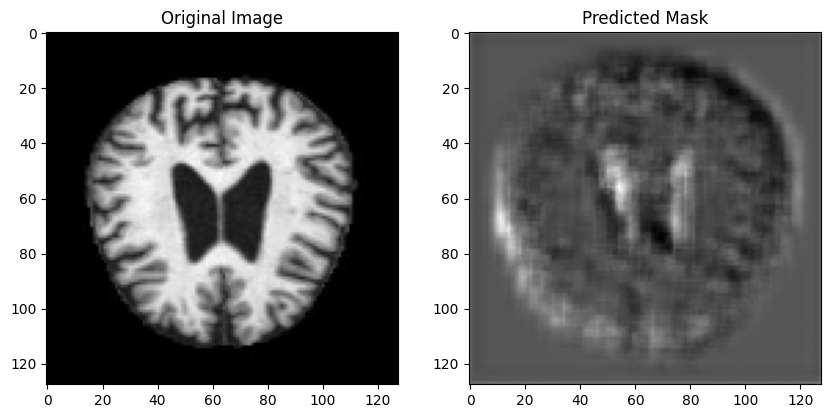

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define U-Net architecture
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)

    # Decoder
    u1 = UpSampling2D((2, 2))(c3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)

    u2 = UpSampling2D((2, 2))(c4)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    # Output layer (single-channel mask)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model

# Initialize and compile U-Net
unet = unet_model()
unet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Placeholder for segmentation masks (you'll need actual masks for real training)
# For demonstration, assume binary masks (0s and 1s) are available in y_train_masks and y_test_masks
y_train_masks = np.random.randint(0, 2, (X_train.shape[0], 128, 128, 1))
y_test_masks = np.random.randint(0, 2, (X_test.shape[0], 128, 128, 1))

# Train U-Net
unet.fit(X_train, y_train_masks, validation_data=(X_test, y_test_masks), epochs=10, batch_size=8)

# Predict a mask for a test image
predicted_mask = unet.predict(X_test[:1])

# Visualize the original image and predicted mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(X_test[0])

plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask[0].reshape(128, 128), cmap='gray')
plt.show()

161/161 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step
Train features shape: (5121, 4, 4, 512)
Test features shape: (1279, 4, 4, 512)


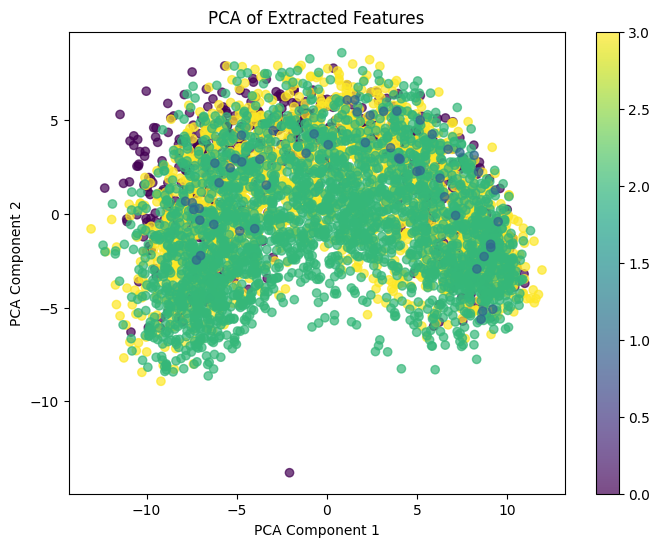

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

# Extract features from the training and testing images
train_features = feature_extractor.predict(X_train, batch_size=32)
test_features = feature_extractor.predict(X_test, batch_size=32)

print(f"Train features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

# Optional: Flatten features for further analysis
train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

# Perform PCA to reduce feature dimensions for visualization
pca = PCA(n_components=2)
reduced_train_features = pca.fit_transform(train_features_flat)

# Visualize the reduced features
plt.figure(figsize=(8, 6))
plt.scatter(reduced_train_features[:, 0], reduced_train_features[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title("PCA of Extracted Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

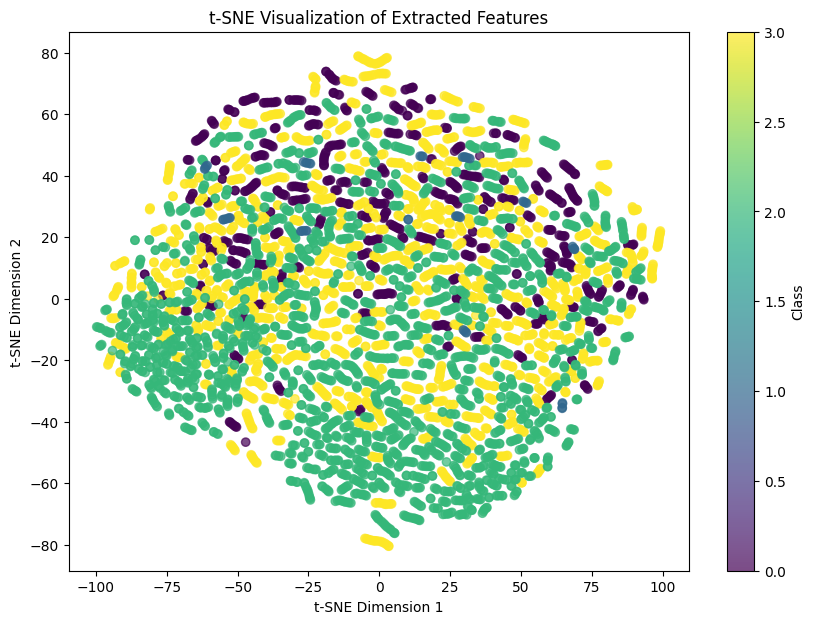

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce feature dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(train_features_flat)  # Flattened feature vectors

# Plot the t-SNE visualization
plt.figure(figsize=(10, 7))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.colorbar(label="Class")
plt.title("t-SNE Visualization of Extracted Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

In [ ]:
# Path to the "all images" folder
all_images_path = os.path.join(extract_path, "Alzheimer_s Dataset/all image")

# Function to load and preprocess images
def preprocess_images(folder_path, img_size=(128, 128)):
    images = []
    image_names = []
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)  # Resize image
            img = img / 255.0  # Normalize pixel values
            images.append(img)
            image_names.append(img_name)  # Keep track of image names
        else:
            print(f"Warning: Unable to read image {img_path}")
    return np.array(images), image_names

# Load and preprocess the images
X_all_images, image_names = preprocess_images(all_images_path)
print(f"Loaded {len(image_names)} images from 'all images' folder")

Loaded 5121 images from 'all images' folder


In [ ]:
# Ensure the input shape matches the feature extractor
if len(X_all_images.shape) == 3:  # If grayscale and missing the channel dimension
    X_all_images = np.repeat(X_all_images[..., np.newaxis], 3, axis=-1)  # Convert grayscale to pseudo-RGB

# Extract features using the pre-trained VGG16 feature extractor
all_features = feature_extractor.predict(X_all_images, batch_size=32)

# Flatten the extracted features
all_features_flat = all_features.reshape(all_features.shape[0], -1)
print(f"Extracted features shape for 'all images': {all_features_flat.shape}")

161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step
Extracted features shape for 'all images': (5121, 8192)


In [ ]:
# Predict the class for each image in the "all images" folder
predicted_classes = clf.predict(all_features_flat)

# Map numerical predictions back to class labels
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Display the predictions
for img_name, label in zip(image_names, predicted_labels):
    print(f"Image: {img_name}, Predicted Label: {label}")

Streaming output truncated to the last 5000 lines.
Image: verymildDem877.jpg, Predicted Label: VeryMildDemented
Image: verymildDem49.jpg, Predicted Label: VeryMildDemented
Image: nonDem15.jpg, Predicted Label: NonDemented
Image: nonDem1215.jpg, Predicted Label: NonDemented
Image: mildDem233.jpg, Predicted Label: MildDemented
Image: verymildDem1478.jpg, Predicted Label: VeryMildDemented
Image: verymildDem963.jpg, Predicted Label: VeryMildDemented
Image: nonDem2240.jpg, Predicted Label: NonDemented
Image: nonDem1458.jpg, Predicted Label: NonDemented
Image: verymildDem1302.jpg, Predicted Label: VeryMildDemented
Image: verymildDem971.jpg, Predicted Label: VeryMildDemented
Image: verymildDem1075.jpg, Predicted Label: VeryMildDemented
Image: verymildDem1264.jpg, Predicted Label: VeryMildDemented
Image: verymildDem1729.jpg, Predicted Label: VeryMildDemented
Image: mildDem649.jpg, Predicted Label: MildDemented
Image: nonDem2260.jpg, Predicted Label: NonDemented
Image: nonDem2410.jpg, Predicted

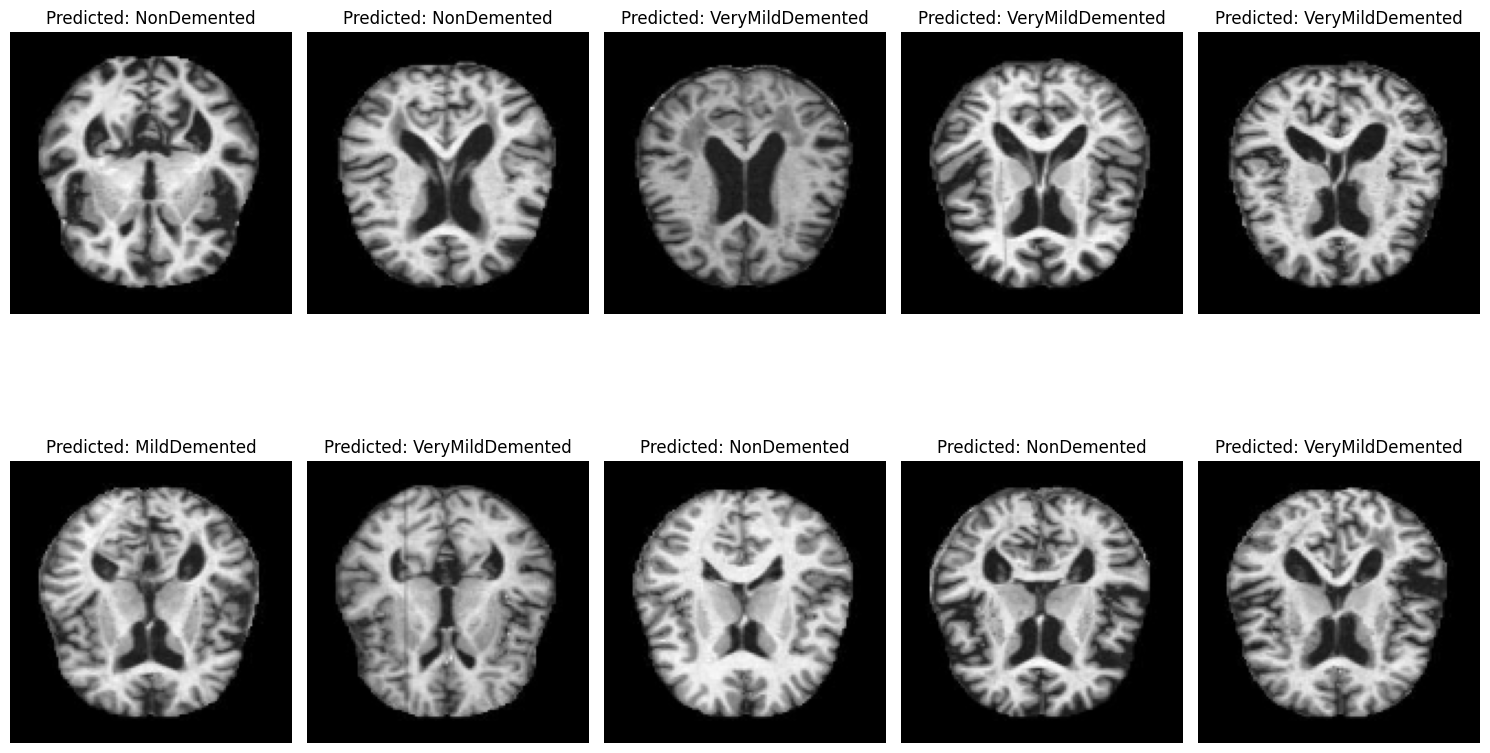

In [ ]:
import matplotlib.pyplot as plt

# Display a few classified images with their predictions
num_images_to_display = 10
plt.figure(figsize=(15, 10))

for i in range(min(num_images_to_display, len(image_names))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_all_images[i])
    plt.title(f"Predicted: {predicted_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()